# Misc dataset

In [1]:
from model.graph_mcmc import Graph_MCMC

In [2]:
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [3]:
import numpy as np


class Graph_Custom (Graph_MCMC):

    def get_feature_names(self):
        feature_name_map = self.G.graph_properties["feat_names"]
        names = []

        for i in range(0, len(feature_name_map)):
            name = feature_name_map[i]
            name = name.replace(";", "-")
            name = name.replace("anonymized feature ", "")
            names.append(name)
        
        return names


    def generate_feature_matrix(self):
        feat_map = self.G.vertex_properties["feat"]
        feat_names = self.get_feature_names()

        vertices = self.G.get_vertices()
        
        N = len(vertices)
        D = len(feat_names)
        X = np.empty((N, D))

        for vertex_index, vertex_id in enumerate(vertices):
            boolean_vector = feat_map[vertex_id]
            for prop_index in range(0, D):
                X[vertex_index, prop_index] = boolean_vector[prop_index]
        
        return X

In [4]:
graph = Graph_Custom()
graph.read_from_ns("ego_social/facebook_1912")

In [5]:
graph.list_props()

name            (graph)   (type: string, val: ego_social (facebook_1912))
description     (graph)   (type: string, val: Ego networks associated with a
                                              set of accounts of three social
                                              media platforms (Facebook,
                                              Google+, and Twitter). Datasets
                                              include node features (profile
                                              metadata), circles, and ego
                                              networks, and were crawled from
                                              public sources in 2012)
citation        (graph)   (type: string, val: ['J. McAuley and J. Leskovec.
                                              "Learning to Discover Social
                                              Circles in Ego Networks." NIPS
                                              (2012). arxiv:1210.8182,
                      

In [6]:
graph.print_info()
graph.partition(B_min=10, B_max=10)

Graph with N=747 nodes, E=30025 edges and D=480 vertex features for training
Performing inference...
Current bracket: (10, 10, 10) (50264.08893840367, 50264.08893840367, 50264.08893840367)
Current bracket: (10, 10, 10) (50264.08893840367, 50264.08893840367, 50264.08893840367)
Bisect at B = 10 with S = 50264.08893840367
Best result: B = 10, S = 50264.08893840367
Done


<VertexPropertyMap object with value type 'int32_t', for Graph 0x7faad7c30b50, at 0x7faad34ee340>

In [7]:
av_dl = graph.mcmc(num_iter=10000)

100%|██████████| 10000/10000 [00:47<00:00, 212.28it/s]


Drawing soft partition


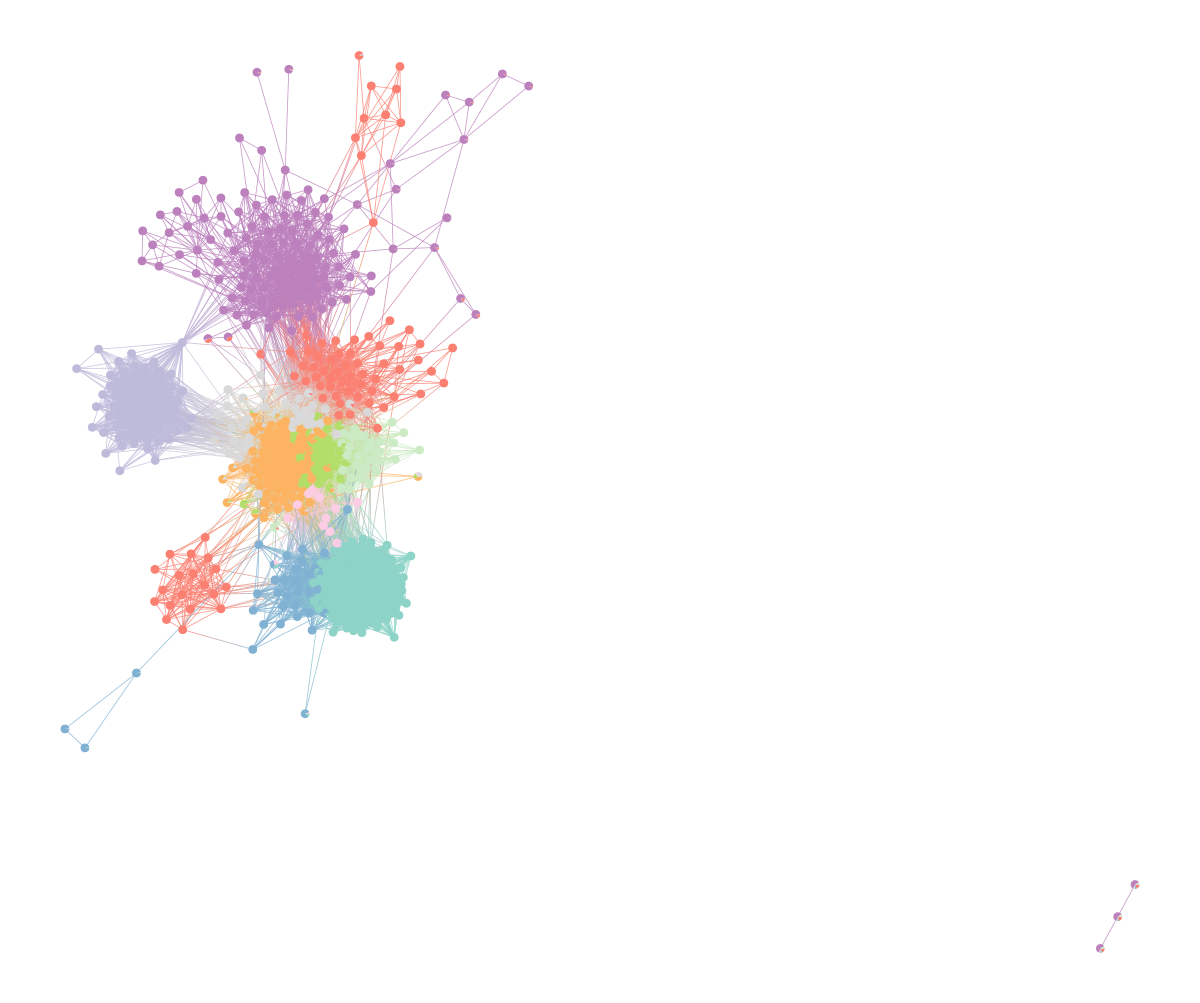

In [8]:
#graph.draw(gen_layout=False, size=10, output="fb-graph.png")
graph.draw(gen_layout=False, size=4)

Drawing block adjacency matrix $e_{rs}$


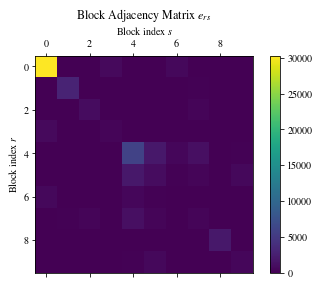

In [9]:
graph.plot_matrix()

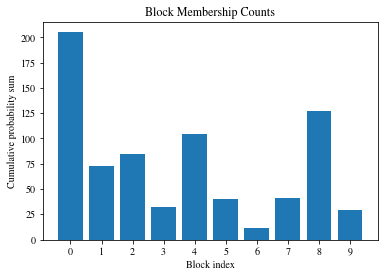

In [10]:
graph.plot_posterior_props()

## Train classifier

In [11]:
from inference.softmax import SoftmaxNeuralNet
import numpy as np

In [12]:
X = graph.generate_feature_matrix()
Y = graph.generate_posterior()

D = X.shape[1]
B = Y.shape[1]

N = X.shape[0]
assert N == Y.shape[0]



In [13]:
from utils.subsampling import random_index_arr

train_indices, test_indices = random_index_arr(N, fraction=0.8)
X_train, Y_train = X[train_indices, :], Y[train_indices, :]
X_test, Y_test = X[test_indices, :], Y[test_indices, :]

In [14]:
classifier = SoftmaxNeuralNet(layers_size=[D, B], sigma=1)
classifier.perform_mala(X_train, Y_train, step_scaling=0.01, num_iter=10000, verbose=True)

100%|██████████| 10000/10000 [03:07<00:00, 53.21it/s] Sample accept ratio: 83.52000000000001%
Train. set accuracy: 60.80402010050251%



(0.8352, 0.6080402010050251)

## Interpret results

### Thinning

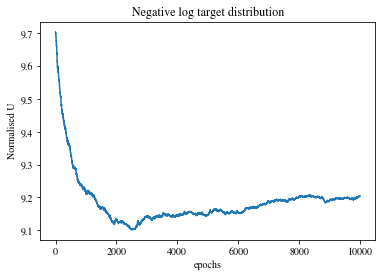

9.18643577767271

In [15]:
classifier.plot_U()

In [16]:
classifier.thin_samples(burn_in_pc=40, thinning_pc=10)

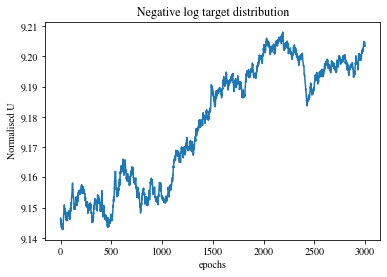

9.177455821446129


In [17]:
u_mean = classifier.plot_U()
print(u_mean)

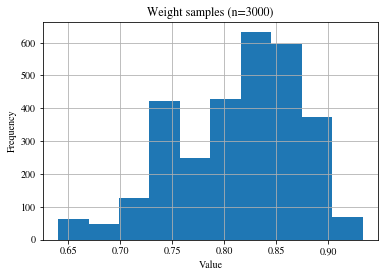

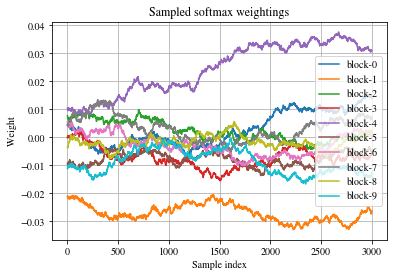

In [18]:
classifier.plot_sample_histogram()
classifier.plot_sample_history()

### Performance

In [19]:
training_loss = classifier.average_loss_per_point(X_train, Y_train, include_prior=False)
test_loss = classifier.average_loss_per_point(X_test, Y_test, include_prior=False)

print("Training loss: {}, Test loss: {}".format(training_loss, test_loss))


Training loss: 1.2888462161442122, Test loss: 1.273245701283309


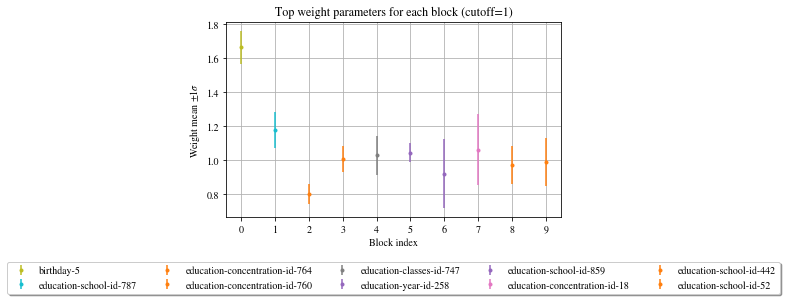

In [20]:
names = list(graph.get_feature_names())
classifier.plot_block_principal_dims(names, cutoff=1, legend=True)

Discarded 474 features


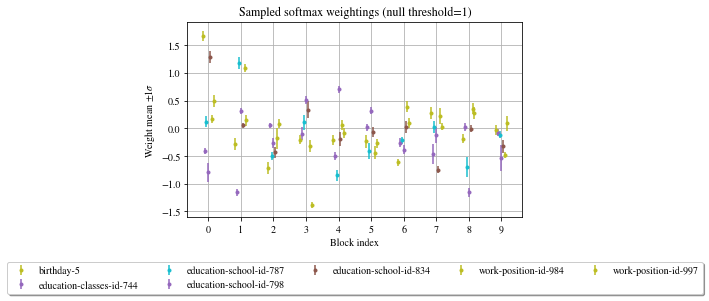

In [21]:
names = list(graph.get_feature_names())
kept_features = classifier.plot_sampled_weights(names, std_dev_multiplier=1, null_space=1, legend=True)

In [22]:
reduced_X_train, reduced_X_test = X_train[:, kept_features], X_test[:, kept_features]

reduced_D = reduced_X_train.shape[1]
B = Y_train.shape[1]

# nwo train new classifier
reduced_classifier = SoftmaxNeuralNet(layers_size=[reduced_D, B], sigma=1)
reduced_classifier.perform_mala(reduced_X_train, Y_train, step_scaling=0.5, num_iter=10000, verbose=True)

100%|██████████| 10000/10000 [00:13<00:00, 739.06it/s]Sample accept ratio: 78.29%
Train. set accuracy: 44.72361809045226%



(0.7829, 0.4472361809045226)

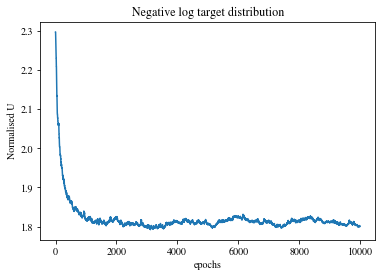

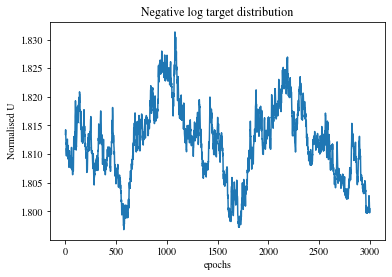

1.8120138123125622

In [23]:
reduced_classifier.plot_U()
reduced_classifier.thin_samples(burn_in_pc=40, thinning_pc=10)
reduced_classifier.plot_U()

In [24]:
reduced_training_loss = reduced_classifier.average_loss_per_point(reduced_X_train, Y_train, include_prior=False)
reduced_test_loss = reduced_classifier.average_loss_per_point(reduced_X_test, Y_test, include_prior=False)

print("REDUCED CLASSIFIER -- Training loss: {}, Test loss: {}".format(reduced_training_loss, reduced_test_loss))

REDUCED CLASSIFIER -- Training loss: 1.6357350085487352, Test loss: 1.469420548472625


In [25]:
print("Average description length per entity: {}".format(av_dl))
print("Training loss: {}, Test loss: {}".format(training_loss, test_loss))
print("D': {}".format(len(kept_features)))
print("REDUCED CLASSIFIER -- Training loss: {}, Test loss: {}".format(reduced_training_loss, reduced_test_loss))

Average description length per entity: 1.6268558349911333
Training loss: 1.2888462161442122, Test loss: 1.273245701283309
D': 7
REDUCED CLASSIFIER -- Training loss: 1.6357350085487352, Test loss: 1.469420548472625
